## Compare the size abundance slope throughought differnt regions of the Arctic Ocean, to understand what is driving the change of the slope

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from numpy import arange,array,ones
from scipy import stats
import re 
import os

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Import general Grid 

In [4]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

## Import the Biomass so that you can calculate the abundance directly
`Regional_analysis_biomass_ssps_hist.ipynb` and the units should be in `mmol C m-2`, however, to convert to `ugC m-3` all I have to do is divide by `150m` and multiply by * `12.011` *`1000` 

In [5]:
# Units should be mmol m-3 (averaged through the top 150m)
path = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/regrid/regrid_pbmss_ch2_1948_2009_'
ppC = xr.open_mfdataset(f'{path}ppC.nc') # mmol m-3
mp1C = xr.open_mfdataset(f'{path}mp1C.nc')# mmol m-3
mp2C = xr.open_mfdataset(f'{path}mp2C.nc')# mmol m-3
mp3C = xr.open_mfdataset(f'{path}mp3C.nc')# mmol m-3
mp4C = xr.open_mfdataset(f'{path}mp4C.nc')# mmol m-3
diat1C = xr.open_mfdataset(f'{path}diat1C.nc')# mmol m-3
diat2C = xr.open_mfdataset(f'{path}diat2C.nc')# mmol m-3
diat3C = xr.open_mfdataset(f'{path}diat3C.nc')# mmol m-3
diazC = xr.open_mfdataset(f'{path}diazC.nc')# mmol m-3

In [7]:
%%time
bmss = np.stack([ppC.ppC_150m_zint, mp1C.mp1C, diazC.diazC,
                   mp2C.mp2C, diat1C.diat1C, diat2C.diat2C, 
                   mp3C.mp3C, diat3C.diat3C, mp4C.mp4C]) 

CPU times: user 754 ms, sys: 3.29 s, total: 4.04 s
Wall time: 5.63 s


In [8]:
bmss_TOT = np.nansum(bmss,axis=0) 
print(f' Total phytoplankton biomass summing phytoC in mmol m-3 {np.sum(bmss_TOT)}')

 Total phytoplankton biomass summing phytoC in mmol m-3 28017930.0


In [9]:
bmss.shape

(9, 62, 12, 180, 360)

### Create lines of the slope at the central Arctic compared to the Nordic Sea
`y = mx+b`

where:

    `m` = np.nanmean(sa_hist_slope[149:170,155:205])
    `b` = np.nanmean(in_hist_slope[149:170,155:205])
    `y` is phytoplankton abundance
    `x` is phytoplankton volumes. 

In [10]:
## Gaby's Path 
gabyn_path = '/glade/work/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595_updated/spectra-config'
nl_config = os.path.join(f'{gabyn_path}/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mass_ugC') # sorting sizes by mass in ugC 
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [11]:
# Sorting mass and names of only the phytoplankton by mass. 
phyto_mass = array([sizes.mass_ugC[1],sizes.mass_ugC[2],sizes.mass_ugC[0],sizes.mass_ugC[3],
                   sizes.mass_ugC[6],sizes.mass_ugC[7],sizes.mass_ugC[4],sizes.mass_ugC[8],
                   sizes.mass_ugC[5]]) # ugC 

phyto_vol = array([sizes.vol_um3[1],sizes.vol_um3[2],sizes.vol_um3[0],sizes.vol_um3[3],
                   sizes.vol_um3[6],sizes.vol_um3[7],sizes.vol_um3[4],sizes.vol_um3[8],
                   sizes.vol_um3[5]]) # units of um^3 (this is good). 

phyto_names = array([sizes.sname[1],sizes.sname[2],sizes.sname[0],sizes.sname[3],
                   sizes.sname[6],sizes.sname[7],sizes.sname[4],sizes.sname[8],
                   sizes.sname[5]])

## Calculate the abundance from the biomass ( $\mu$g C m$^{-3}$)

In [12]:
pbmss = np.nanmean(bmss[:,42:64,:,:,:],axis=1)*(12.011*1000) # converting from mmolC -3 to ug C m-3 (average through the last 20 years). 

In [13]:
pbmss.shape

(9, 12, 180, 360)

In [14]:
# This deletes the dizotrophs from the array - np.delete(pb_ssp2,1,1)
phyto_mass.shape

(9,)

In [15]:
%%time
# calcualte the abundance of each phytoplankton with biomass and mass in the same order. 
phyto_abu = np.zeros((9,12,180,360))
for i in range(9):
    phyto_abu[i,:,:] = pbmss[i,:,:,:]/phyto_mass[i] # ug C cm^{-3} / ug C -->  cell/ m^3 

CPU times: user 8.84 ms, sys: 20.8 ms, total: 29.6 ms
Wall time: 35.8 ms


Text(0.03, 0.5, 'Phytoplankton log abundance (cells m$^{-3}$)')

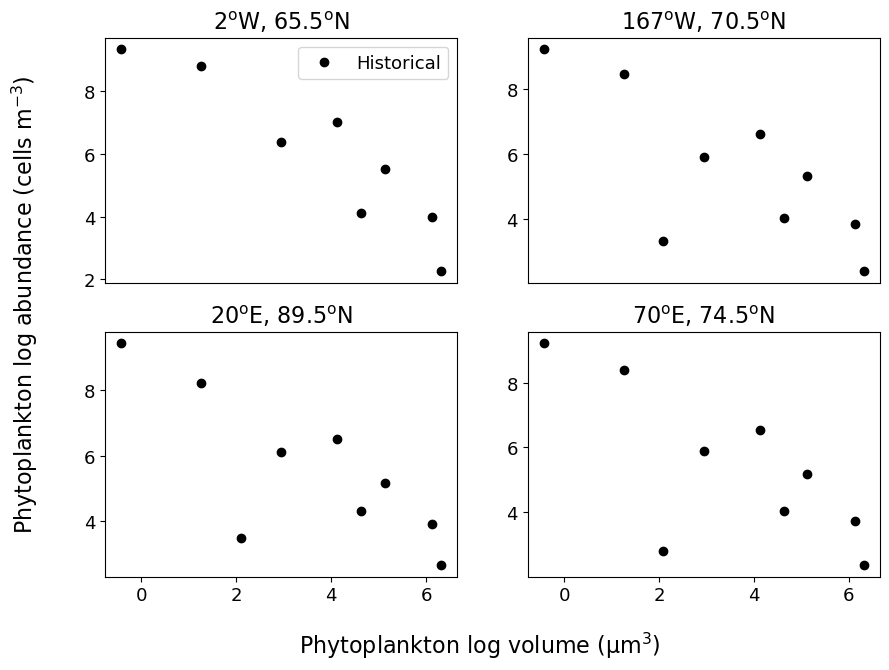

In [16]:
fig = plt.figure(figsize=(10, 7))
sfont=13
font=16

#subplot 1
ax1 = fig.add_subplot(2, 2, 1)
lnsp1 = ax1.plot(np.log10(phyto_vol),np.log10(np.nanmean(phyto_abu[:,:,155,178],axis=1)), 'o', color='k',linewidth=3,label='20yrclim');
ax1.tick_params(axis='both',labelsize=sfont);
ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('2$^o$W, 65.5$^o$N',fontsize=font)

ax1 = fig.add_subplot(2, 2, 2)
lnsp2 = ax1.plot(np.log10(phyto_vol),np.log10(np.nanmean(phyto_abu[:,:,160,3],axis=1)), 'o', color='k',linewidth=3,label='20yrclim');
ax1.tick_params(axis='both',labelsize=sfont);
#ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('167$^o$W, 70.5$^o$N',fontsize=font)

ax1 = fig.add_subplot(2, 2, 3)
lnsp3 = ax1.plot(np.log10(phyto_vol),np.log10(np.nanmean(phyto_abu[:,:,179,200],axis=1)), 'o', color='k',linewidth=3,label='20yrclim');
ax1.tick_params(axis='both',labelsize=sfont);
#ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
ax1.set_title('20$^o$E, 89.5$^o$N',fontsize=font)

ax1 = fig.add_subplot(2, 2, 4)
lnsp4 = ax1.plot(np.log10(phyto_vol),np.log10(np.nanmean(phyto_abu[:,:,164,250],axis=1)), 'o', color='k',linewidth=3,label='20yrclim');
ax1.tick_params(axis='both',labelsize=sfont);
#ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
ax1.set_title('70$^o$E, 74.5$^o$N',fontsize=font)

fig.text(0.5, 0.001, 'Phytoplankton log volume ($\mu$m$^3$)', ha='center',fontsize=font)
fig.text(0.03, 0.5, 'Phytoplankton log abundance (cells m$^{-3}$)', va='center', rotation='vertical',fontsize=font)
#file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
#fig.savefig(f'{file}sa_hist_ssp2_regional.png',dpi=600, bbox_inches='tight')

### Calculate the slope and intercept directly at one location to see how it compares when you calculate as a loop

In [17]:
stats.linregress(np.log10(phyto_vol+1),np.log10(np.nanmean(phyto_abu[:,:,155,178],axis=1)))

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [18]:
xp = np.log10(phyto_vol+1)
yp_results_155_178 = np.empty((12,5))
for i in range(12):
    yp_results_155_178[i] = stats.linregress(xp, np.log10(phyto_abu[:,i,155,178]))

In [19]:
np.nanmean(yp_results_155_178,axis=0)

array([nan, nan, nan, nan, nan])

## The comparison is a few decimals off, but very similar. 

### Now calculate for each grid cell, and see how that comaprd 

In [20]:
%%time
m=12
xp = np.log10(phyto_vol+1)
phyto_abu[phyto_abu<0] = 0
phyto_abu_log = np.log10(phyto_abu[:,:,:,:]+1)
yp_hist = np.empty((12,180,360, 5))
for i in range(12):
    for lat in range(180):
        for lon in range(360):
            yp_hist[i,lat,lon,:] = stats.linregress(xp, phyto_abu_log[:,i,lat,lon])

CPU times: user 1min 32s, sys: 338 ms, total: 1min 32s
Wall time: 1min 37s


### There are now a few more differences in errors, but not huge, and it migth be worth it since it compares a lot more than the already calcualted in a pop grid and then regrided, which provided quite a difference in both slope and intercept

In [21]:
diat1C.lon

<xarray.DataArray 'lon' (lon: 360)>
array([-180., -179., -178., ...,  177.,  178.,  179.])
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

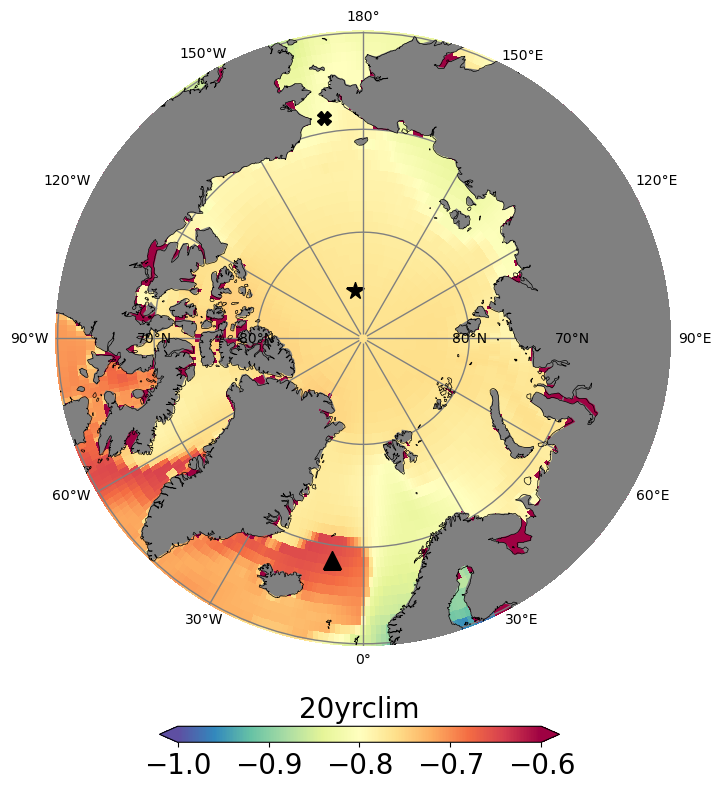

In [22]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

r_limit = 3214068.5 #from: ax.get_ylim() of above plot
vminn=-1
vmaxx=-0.6
# some settings  
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=0, central_latitude=90)
fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(1, 1, 1, projection=my_projn)

data, lon = add_cyclic_point(np.nanmean(yp_hist[:,:,:,0],axis=0), coord=diat1C.lon, axis=1)
x, y = np.meshgrid(lon,diat1C.lat)
cf = ax.pcolormesh(x,y,data,cmap='Spectral_r',transform=lonlatproj,vmin=vminn, vmax=vmaxx)

# 7$^o$W, 64.5$^o$N
x1, y1 = np.meshgrid(diat1C.lon[10],diat1C.lat[158])
ax.plot(x1,y1,'X',color='k',ms=10,fillstyle='full',transform=lonlatproj)

# 20$^o$E, 89.5$^o$N
x3, y3 = np.meshgrid(diat1C.lon[10],diat1C.lat[175])
ax.plot(x3,y3,'*',color='k',ms=13,fillstyle='full',transform=lonlatproj)

# 150$^o$E, 72.5$^o$N
x4, y4 = np.meshgrid(diat1C.lon[172],diat1C.lat[158])
ax.plot(x4,y4,'^',color='k',ms=13,fillstyle='full',transform=lonlatproj)

# add bluemarble image
# add coastlines
ax.coastlines(lw=0.5, color="black", zorder=20)


# draw graticule (of meridian and parallel lines)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))


# add extra padding to the plot extents
r_extent = r_limit*1.0001
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())

#set circle boundary
ax.set_boundary(circle_path)
#hide frame
ax.set_frame_on(False)  #hide the rectangle frame
cbar_ax = fig.add_axes([0.258, -0.01, 0.5, 0.02])
cb = fig.colorbar(cf, shrink=1, extend ='both',orientation='horizontal', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('20yrclim', fontsize=20)
plt.show()

In [23]:
abu_hist = np.nanmean(phyto_abu_log,axis=1)
sa_hist = np.nanmean(yp_hist,axis=0)

Y_hist_k = (sa_hist[158,10,0]*np.log10(phyto_vol))+sa_hist[158,10,1]
Y_hist_r = (sa_hist[175,10,0]*np.log10(phyto_vol))+sa_hist[175,10,1]
Y_hist_b = (sa_hist[158,172,0]*np.log10(phyto_vol))+sa_hist[158,172,1]

Text(0.03, 0.5, 'Phytoplankton log abundance (cells m$^{-3}$)')

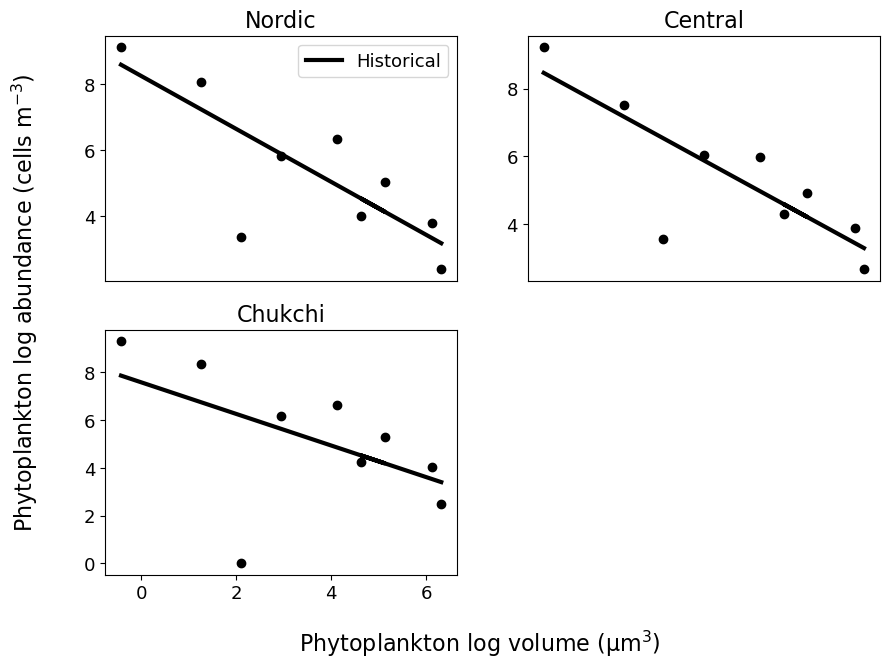

In [24]:
fig = plt.figure(figsize=(10, 7))
sfont=13
font=16

#subplot 1
ax1 = fig.add_subplot(2, 2, 1)
lnsp1 = ax1.plot(np.log10(phyto_vol),abu_hist[:,158,10], 'o', color='k',linewidth=3,label='Historical');
lnsp = ax1.plot(np.log10(phyto_vol),Y_hist_k, '-', color='k',linewidth=3,label='Historical');
ax1.tick_params(axis='both',labelsize=sfont);
ax1.legend(lnsp,['Historical'],fontsize=sfont)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('Nordic',fontsize=font)

ax1 = fig.add_subplot(2, 2, 2)
lnsp2 = ax1.plot(np.log10(phyto_vol),abu_hist[:,175,10], 'o', color='k',linewidth=3,label='Historical');
lnsp2 = ax1.plot(np.log10(phyto_vol),Y_hist_r, '-', color='k',linewidth=3,label='Historical');
ax1.tick_params(axis='both',labelsize=sfont);
#ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('Central',fontsize=font)

ax1 = fig.add_subplot(2, 2, 3)
lnsp3 = ax1.plot(np.log10(phyto_vol),abu_hist[:,158,172], 'o', color='k',linewidth=3,label='Historical');
lnsp3 = ax1.plot(np.log10(phyto_vol),Y_hist_b, '-', color='k',linewidth=3,label='Historical');
ax1.tick_params(axis='both',labelsize=sfont);
#ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
ax1.set_title('Chukchi',fontsize=font)


fig.text(0.5, 0.001, 'Phytoplankton log volume ($\mu$m$^3$)', ha='center',fontsize=font)
fig.text(0.03, 0.5, 'Phytoplankton log abundance (cells m$^{-3}$)', va='center', rotation='vertical',fontsize=font)

In [25]:
phyto_abu_log.shape

(9, 12, 180, 360)

In [27]:
abu_hist = np.nanmean(phyto_abu_log,axis=1)
sa_hist = np.nanmean(yp_hist,axis=0)
Y_hist_k = np.empty((12,9))
Y_hist_r = np.empty((12,9))
Y_hist_b = np.empty((12,9))
for i in range(12):
    Y_hist_k[i,:] = (yp_hist[i,158,10,0]*np.log10(phyto_vol))+yp_hist[i,158,10,1]
    Y_hist_r[i,:] = (yp_hist[i,175,10,0]*np.log10(phyto_vol))+yp_hist[i,175,10,1]
    Y_hist_b[i,:] = (yp_hist[i,158,172,0]*np.log10(phyto_vol))+yp_hist[i,158,172,1]

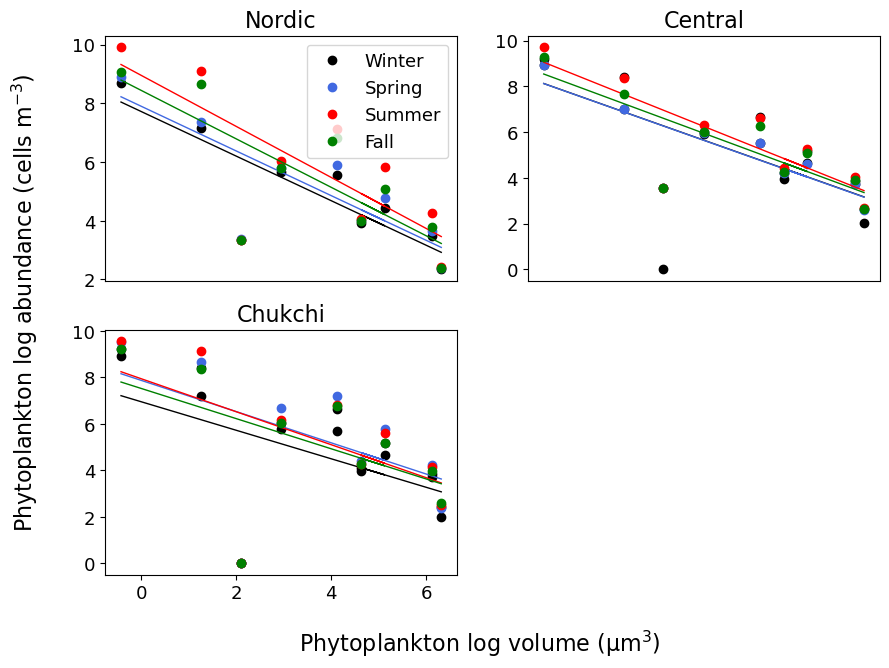

In [28]:
fig = plt.figure(figsize=(10, 7))
sfont=13
font=16

#subplot 1
ax1 = fig.add_subplot(2, 2, 1)
#lnsp1 = ax1.plot(np.log10(phyto_vol),abu_hist[:,154,173], 'o', color='k',linewidth=3,label='Historical');
lnsp1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[list(range(2)) + [-1],:],axis=0), '-', color='k',linewidth=1,label='winter');
lnsp1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,list(range(2)) + [-1],158,10],axis=1), 'o', color='k',linewidth=1,label='winter');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[2:5,:],axis=0), '-', color='royalblue',linewidth=1,label='spring');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,2:5,158,10],axis=1), 'o', color='royalblue',linewidth=1,label='spring');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[5:8,:],axis=0), '-', color='red',linewidth=1,label='summer');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,5:8,158,10],axis=1), 'o', color='red',linewidth=1,label='summer');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[8:11,:],axis=0), '-', color='green',linewidth=1,label='fall');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,8:11,158,10],axis=1), 'o', color='green',linewidth=1,label='fall');
ax1.tick_params(axis='both',labelsize=sfont);
ax1.legend(lnsp1+lnsp+lns+lns1,['Winter','Spring','Summer','Fall'],fontsize=sfont)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('Nordic',fontsize=font)

ax1 = fig.add_subplot(2, 2, 2)
lnsp1 = ax1.plot(np.log10(phyto_vol),abu_hist[:,154,173], 'o', color='k',linewidth=3,label='Historical');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[list(range(2)) + [-1],:],axis=0), '-', color='k',linewidth=1,label='winter');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,list(range(2)) + [-1],175,10],axis=1), 'o', color='k',linewidth=1,label='winter');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[2:5,:],axis=0), '-', color='royalblue',linewidth=1,label='spring');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,2:5,175,10],axis=1), 'o', color='royalblue',linewidth=1,label='spring');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[5:8,:],axis=0), '-', color='red',linewidth=1,label='summer');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,5:8,175,10],axis=1), 'o', color='red',linewidth=1,label='summer');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[8:11,:],axis=0), '-', color='green',linewidth=1,label='fall');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,8:11,175,10],axis=1), 'o', color='green',linewidth=1,label='fall');
ax1.tick_params(axis='both',labelsize=sfont);
#ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('Central',fontsize=font)

ax1 = fig.add_subplot(2, 2, 3)
lnsp1 = ax1.plot(np.log10(phyto_vol),abu_hist[:,154,173], 'o', color='k',linewidth=3,label='Historical');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[list(range(2)) + [-1],:],axis=0), '-', color='k',linewidth=1,label='winter');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,list(range(2)) + [-1],158,172],axis=1), 'o', color='k',linewidth=1,label='winter');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[2:5,:],axis=0), '-', color='royalblue',linewidth=1,label='spring');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,2:5,158,172],axis=1), 'o', color='royalblue',linewidth=1,label='spring');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[5:8,:],axis=0), '-', color='red',linewidth=1,label='summer');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,5:8,158,172],axis=1), 'o', color='red',linewidth=1,label='summer');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[8:11,:],axis=0), '-', color='green',linewidth=1,label='fall');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,8:11,158,172],axis=1), 'o', color='green',linewidth=1,label='fall');
ax1.tick_params(axis='both',labelsize=sfont);
#ax1.legend(['Historical','SSP2-4.5'],fontsize=sfont)
ax1.set_title('Chukchi',fontsize=font)

fig.text(0.5, 0.001, 'Phytoplankton log volume ($\mu$m$^3$)', ha='center',fontsize=font)
fig.text(0.03, 0.5, 'Phytoplankton log abundance (cells m$^{-3}$)', va='center', rotation='vertical',fontsize=font)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}supp_fig_slopes_regional_seasonal.png',dpi=600, bbox_inches='tight')

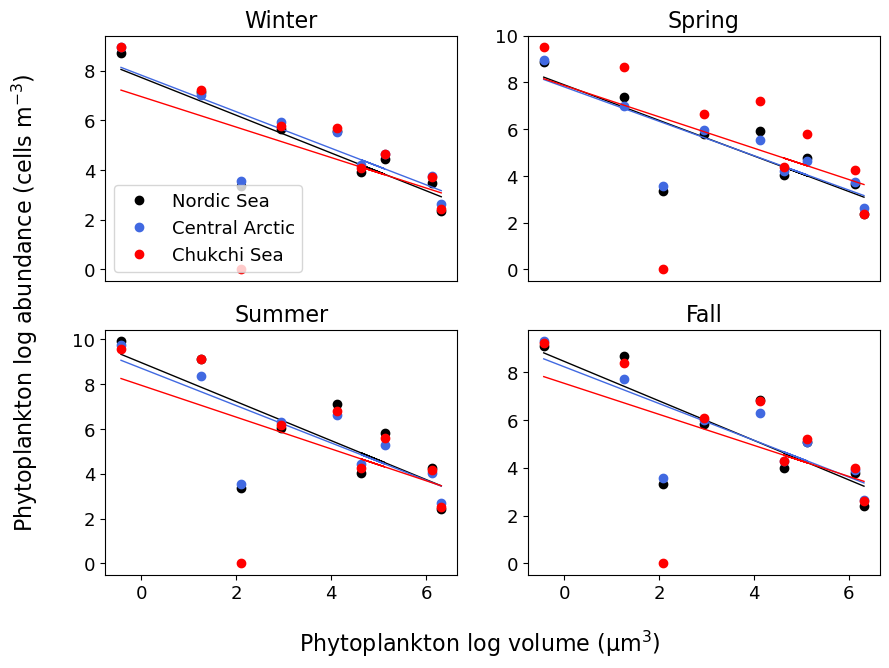

In [29]:
fig = plt.figure(figsize=(10, 7))
sfont=13
font=16

#subplot 1
ax1 = fig.add_subplot(2, 2, 1)
#lnsp1 = ax1.plot(np.log10(phyto_vol),abu_hist[:,154,173], 'o', color='k',linewidth=3,label='Historical');
lnsp1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[list(range(2)) + [-1],:],axis=0), '-', color='k',linewidth=1,label='winter');
lnsp1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,list(range(2)) + [-1],158,10],axis=1), 'o', color='k',linewidth=1,label='winter');

lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[list(range(2)) + [-1],:],axis=0), '-', color='royalblue',linewidth=1,label='winter');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,list(range(2)) + [-1],175,10],axis=1), 'o', color='royalblue',linewidth=1,label='winter');

lns = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[list(range(2)) + [-1],:],axis=0), '-', color='red',linewidth=1,label='winter');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,list(range(2)) + [-1],158,172],axis=1), 'o', color='red',linewidth=1,label='winter');

ax1.tick_params(axis='both',labelsize=sfont);
ax1.legend(lnsp1+lnsp+lns,['Nordic Sea','Central Arctic','Chukchi Sea'],fontsize=sfont)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('Winter',fontsize=font)

ax1 = fig.add_subplot(2, 2, 2)

lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[2:5,:],axis=0), '-', color='k',linewidth=1,label='spring');
lnsp = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,2:5,158,10],axis=1), 'o', color='k',linewidth=1,label='spring');

lns = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[2:5,:],axis=0), '-', color='royalblue',linewidth=1,label='spring');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,2:5,175,10],axis=1), 'o', color='royalblue',linewidth=1,label='spring');

lns = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[2:5,:],axis=0), '-', color='red',linewidth=1,label='spring');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,2:5,158,172],axis=1), 'o', color='red',linewidth=1,label='spring');

ax1.tick_params(axis='both',labelsize=sfont);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.set_title('Spring',fontsize=font)

ax1 = fig.add_subplot(2, 2, 3)
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[5:8,:],axis=0), '-', color='k',linewidth=1,label='summer');
lns = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,5:8,158,10],axis=1), 'o', color='k',linewidth=1,label='summer');

lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[5:8,:],axis=0), '-', color='royalblue',linewidth=1,label='summer');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,5:8,175,10],axis=1), 'o', color='royalblue',linewidth=1,label='summer');

lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[5:8,:],axis=0), '-', color='red',linewidth=1,label='summer');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,5:8,158,172],axis=1), 'o', color='red',linewidth=1,label='summer');

ax1.tick_params(axis='both',labelsize=sfont);
ax1.set_title('Summer',fontsize=font)

ax1 = fig.add_subplot(2, 2, 4)

lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_k[8:11,:],axis=0), '-', color='k',linewidth=1,label='fall');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,8:11,158,10],axis=1), 'o', color='k',linewidth=1,label='fall');

lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_r[8:11,:],axis=0), '-', color='royalblue',linewidth=1,label='fall');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,8:11,175,10],axis=1), 'o', color='royalblue',linewidth=1,label='fall');

lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(Y_hist_b[8:11,:],axis=0), '-', color='red',linewidth=1,label='fall');
lns1 = ax1.plot(np.log10(phyto_vol),np.nanmean(phyto_abu_log[:,8:11,158,172],axis=1), 'o', color='red',linewidth=1,label='fall');

ax1.tick_params(axis='both',labelsize=sfont);
ax1.set_title('Fall',fontsize=font)

fig.text(0.5, 0.001, 'Phytoplankton log volume ($\mu$m$^3$)', ha='center',fontsize=font)
fig.text(0.03, 0.5, 'Phytoplankton log abundance (cells m$^{-3}$)', va='center', rotation='vertical',fontsize=font)
file = '/glade/u/home/gabyn/work/case_notes/analysis_figures/'
fig.savefig(f'{file}supp_fig_slopes_seasonal_regional.png',dpi=600, bbox_inches='tight')